In [18]:
from llm.context.llm_context import LLMContext
from llm.strategy.big_llama_model import BigLlamaModel
from llm.strategy.big_llama3_1_model import BigLlama3_1Model
from llm.strategy.small_llama_model import SmallLlamaModel
from llm.strategy.big_mistral_model import BigMistralModel
from llm.strategy.haiku3_model import Haiku3Model
from llm.strategy.sonet3_model import Sonet3Model
from llm.strategy.opus3_model import OpusModel
from llm.strategy.sonet3_5_model import Sonet3_5Model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from tqdm import tqdm
import os
import numpy as np 
import pandas as pd
import re
import warnings
import spacy

In [20]:
PATH = './data/processed/txt'

In [3]:
def get_text_and_masked_carmen(name):
    filename_result = f'./data/processed/masked/{name}'

    with open(filename_result, 'r') as archivo:
        text_masked = archivo.read()

    csv_data = f'./data/processed/ann/{name.split(".")[0]}.csv'
    result_dict = {}
    df = pd.read_csv((csv_data), header=None)
    for index, row in df.iterrows():
        result_dict[row[3]] = row[0]
    return [text_masked, result_dict]

# METRICS

In [4]:
def compute_classification_agreement(dict1, dict2):
    # Look for key disagreement
    keys_not_present_in_dict2 = list(set(dict1.keys()) - set(dict2.keys()))
    
    # look for misclassifications
    disagreement_in_values = {}
    for key in dict1.keys() & dict2.keys():
        if dict1[key] != dict2[key]:
            disagreement_in_values[key] = (dict1[key], dict2[key])

    return disagreement_in_values, keys_not_present_in_dict2

# Loop

In [29]:
def store_metrics(real, predicted,fails, miss, metrics_data):
    metrics_data["total"] = len(real.keys())
    total_fails = len(fails.keys()) + len(miss)
    metrics_data["correct"] = len(real.keys()) - total_fails
    metrics_data["total_fails"] = total_fails
    metrics_data["precision"] = 100 - (total_fails * 100 / len(real.keys()))
    metrics_data["real"] = real
    metrics_data["predicted"] = predicted
    metrics_data["fails"] = fails
    metrics_data["miss"] = miss
    return metrics_data

In [30]:
def save_metrics(name_model, list_data):
    list_data = pd.DataFrame(list_data)
    list_data.to_csv(f'data/metrics/second_step/{name_model}.csv')

In [31]:
import json
def anonimized(llm=None, name_model="", data=None):
    counter = 0
    context = LLMContext(llm)
    list_data  = []
    for filename in sorted(os.listdir(PATH)):
        print(filename)
        metrics_data = {}
        metrics_data["filename"] = filename
        try:
            [text_masked, array_ground_truth] = get_text_and_masked_carmen(filename)
            data["user"] = text_masked
            text_generated = context.generate_response(data)
            array_of_dicts = json.loads(text_generated)
            merged_dict = {}
            for d in array_of_dicts:
                merged_dict.update(d)
            diferencias, unicas_dict1 = compute_classification_agreement(array_ground_truth, merged_dict)
            metrics_data = store_metrics(array_ground_truth, merged_dict, diferencias, unicas_dict1, metrics_data)
            list_data.append(metrics_data)
            counter += 1
            if counter >= 100:
                break
        except Exception as e:
            print("Error")
            print(e)
            continue
    save_metrics(name_model, list_data)

In [17]:
data = {}
data["system"] = """
You are a clasification tool. 
You have the ability to identify quasi-identifying attributes which are in [**  **] simbols.
Then you will return an array with the anonymized attributes in the order they appear in the text.

Las posibles etiquetas son:
- 'FAMILIARES_SUJETO_ASISTENCIA'
- 'FECHAS'
- 'NUMERO_TELEFONO'
- 'OTROS_SUJETO_ASISTENCIA'
- 'INSTITUCION'
- 'NUMERO_IDENTIF'
- 'EDAD_SUJETO_ASISTENCIA'
- 'HOSPITAL'
- 'PAIS'
- 'TERRITORIO'
- 'NOMBRE_PERSONAL_SANITARIO'
- 'PROFESION'
- 'ID_SUJETO_ASISTENCIA'
- 'CENTRO_SALUD'
- 'SEXO_SUJETO_ASISTENCIA'
- 'CALLE'
- 'ID_CONTACTO_ASISTENCIAL'
- 'URL_WEB'


Examples:
Paciente de [**41 años**], [**albañil**], con dolor lumbar crónico y problemas de movilidad. = [{"41 años": "EDAD_SUJETO_ASISTENCIA"}, {"albañil": "PROFESION"}]

Do not comment anything else. Just return the array.

"""

In [18]:
print(len(data["system"]))

835


# Function to get labels

In [33]:
# import pandas as pd
# import os
# PATH = './data/processed/ann'
# array_options = []
# for filename in sorted(os.listdir(PATH)):
#     filename_result = f'./data/processed/ann/{filename}'
#     data = pd.read_csv(filename_result)
#     array_options.append(data.iloc[:, 0])

# combined_options = [item for sublist in array_options for item in sublist]
# unique_options_ordered = list(dict.fromkeys(combined_options))
# unique_options_ordered

In [34]:
anonimized(llm=BigLlamaModel(), name_model="big_llama3", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARMEN-I_IA_ANTECEDENTES_111.txt
CARMEN-I_IA_ANTECEDENTES_112.txt
CARMEN-I_IA_ANTECEDENTES_113.txt
CARMEN-I_IA_ANTECEDENTES_114.txt
CARMEN-I_IA_ANTECEDENTES_115.txt
CARMEN-I_IA_ANTECEDENTES_116.txt
CARMEN-I_IA_ANTECEDENTES_117.txt
CARMEN-I_IA_ANTECEDENTES_118.txt
CARMEN-I_IA_ANTECEDENTES_119.txt
CARMEN-I_IA_ANTECEDENTES_12.txt
CARMEN-I_IA_ANTECEDENTES_120.txt
CARMEN-I_IA_ANTECEDENTES_121.txt
CARMEN-I_IA_ANTECEDENTES_122.txt
CARMEN-I_IA_ANTECEDENTES

In [35]:
anonimized(llm=BigLlama3_1Model(), name_model="big_llama3_1", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARMEN-I_IA_ANTECEDENTES_111.txt
CARMEN-I_IA_ANTECEDENTES_112.txt
CARMEN-I_IA_ANTECEDENTES_113.txt
CARMEN-I_IA_ANTECEDENTES_114.txt
CARMEN-I_IA_ANTECEDENTES_115.txt
CARMEN-I_IA_ANTECEDENTES_116.txt
CARMEN-I_IA_ANTECEDENTES_117.txt
CARMEN-I_IA_ANTECEDENTES_118.txt
CARMEN-I_IA_ANTECEDENTES_119.txt
CARMEN-I_IA_ANTECEDENTES_12.txt
CARMEN-I_IA_ANTECEDENTES_120.txt
CARMEN-I_IA_ANTECEDENTES_121.txt
CARMEN-I_IA_ANTECEDENTES_122.txt
CARMEN-I_IA_ANTECEDENTES

In [36]:
anonimized(llm=SmallLlamaModel(), name_model="small_llam", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
Error
Expecting ',' delimiter: line 1 column 329 (char 328)
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
Error
Expecting property name enclosed in double quotes: line 1 column 4 (char 3)
CARMEN-I_IA_ANTECEDENTES_10.txt
Error
Expecting ',' delimiter: line 1 column 260 (char 259)
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
Error
Expecting property name enclosed in double quotes: line 1 column 4 (char 3)
CARMEN-I_IA_ANTECEDENTES_102.txt
Error
Expecting property name enclosed in double quotes: line 1 column 4 (char 3)
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
Error
Expecting property name enclosed in double quotes: line 1 column 4 (char 3)
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARM

In [37]:
anonimized(llm=BigMistralModel(), name_model="big_mistral", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
Error
Unterminated string starting at: line 3 column 2 (char 25)
CARMEN-I_CC_3.txt
Error
Unterminated string starting at: line 3 column 2 (char 24)
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
Error
Unterminated string starting at: line 8 column 2 (char 171)
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
Error
Unterminated string starting at: line 6 column 2 (char 120)
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
Error
Unterminated string starting at: line 5 column 2 (char 119)
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
Error
Unterminated string starting at: line 5 column 2 (char 103)
CARMEN-I_IA_ANTECEDENTES_11.txt
Error
Unterminated string starting at: line 3 column 2 (char 43)
CARMEN-I_IA_ANTECEDENTES_1

In [38]:
anonimized(llm=Haiku3Model(), name_model="haiku_3", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARMEN-I_IA_ANTECEDENTES_111.txt
CARMEN-I_IA_ANTECEDENTES_112.txt
CARMEN-I_IA_ANTECEDENTES_113.txt
CARMEN-I_IA_ANTECEDENTES_114.txt
CARMEN-I_IA_ANTECEDENTES_115.txt
CARMEN-I_IA_ANTECEDENTES_116.txt
CARMEN-I_IA_ANTECEDENTES_117.txt
CARMEN-I_IA_ANTECEDENTES_118.txt
CARMEN-I_IA_ANTECEDENTES_119.txt
CARMEN-I_IA_ANTECEDENTES_12.txt
CARMEN-I_IA_ANTECEDENTES_120.txt
CARMEN-I_IA_ANTECEDENTES_121.txt
CARMEN-I_IA_ANTECEDENTES_122.txt
CARMEN-I_IA_ANTECEDENTES

In [39]:
anonimized(llm=Sonet3Model(), name_model="sonet3", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARMEN-I_IA_ANTECEDENTES_111.txt
CARMEN-I_IA_ANTECEDENTES_112.txt
CARMEN-I_IA_ANTECEDENTES_113.txt
CARMEN-I_IA_ANTECEDENTES_114.txt
CARMEN-I_IA_ANTECEDENTES_115.txt
CARMEN-I_IA_ANTECEDENTES_116.txt
CARMEN-I_IA_ANTECEDENTES_117.txt
CARMEN-I_IA_ANTECEDENTES_118.txt
CARMEN-I_IA_ANTECEDENTES_119.txt
CARMEN-I_IA_ANTECEDENTES_12.txt
CARMEN-I_IA_ANTECEDENTES_120.txt
CARMEN-I_IA_ANTECEDENTES_121.txt
CARMEN-I_IA_ANTECEDENTES_122.txt
CARMEN-I_IA_ANTECEDENTES

In [40]:
anonimized(llm=OpusModel(), name_model="opus3", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARMEN-I_IA_ANTECEDENTES_111.txt
CARMEN-I_IA_ANTECEDENTES_112.txt
CARMEN-I_IA_ANTECEDENTES_113.txt
CARMEN-I_IA_ANTECEDENTES_114.txt
CARMEN-I_IA_ANTECEDENTES_115.txt
CARMEN-I_IA_ANTECEDENTES_116.txt
CARMEN-I_IA_ANTECEDENTES_117.txt
CARMEN-I_IA_ANTECEDENTES_118.txt
CARMEN-I_IA_ANTECEDENTES_119.txt
CARMEN-I_IA_ANTECEDENTES_12.txt
CARMEN-I_IA_ANTECEDENTES_120.txt
CARMEN-I_IA_ANTECEDENTES_121.txt
CARMEN-I_IA_ANTECEDENTES_122.txt
CARMEN-I_IA_ANTECEDENTES

In [41]:
anonimized(llm=Sonet3_5Model(), name_model="sonet3_5", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARMEN-I_IA_ANTECEDENTES_111.txt
CARMEN-I_IA_ANTECEDENTES_112.txt
CARMEN-I_IA_ANTECEDENTES_113.txt
CARMEN-I_IA_ANTECEDENTES_114.txt
CARMEN-I_IA_ANTECEDENTES_115.txt
CARMEN-I_IA_ANTECEDENTES_116.txt
CARMEN-I_IA_ANTECEDENTES_117.txt
CARMEN-I_IA_ANTECEDENTES_118.txt
CARMEN-I_IA_ANTECEDENTES_119.txt
CARMEN-I_IA_ANTECEDENTES_12.txt
CARMEN-I_IA_ANTECEDENTES_120.txt
CARMEN-I_IA_ANTECEDENTES_121.txt
CARMEN-I_IA_ANTECEDENTES_122.txt
CARMEN-I_IA_ANTECEDENTES

# Precision

In [42]:
OpusModel_data = pd.read_csv('./data/metrics/second_step/opus3.csv')
print(OpusModel_data["precision"].mean())

95.69139622137334


In [43]:
Haiku3_data = pd.read_csv('./data/metrics/second_step/haiku_3.csv')
print(Haiku3_data["precision"].mean())

92.83210976793356


In [44]:
Sonet3_data = pd.read_csv('./data/metrics/second_step/sonet3.csv')
print(Sonet3_data["precision"].mean())

94.14861479227613


In [45]:
small_llama_data = pd.read_csv('./data/metrics/second_step/small_llam.csv')
print(small_llama_data["precision"].mean())

72.20586813771024


In [46]:
big_llama_data = pd.read_csv('./data/metrics/second_step/big_llama3.csv')
print(big_llama_data["precision"].mean())

93.12362842281034


In [ ]:
categorize(llm=Sonet3_1Model(), name_model="sonet3_1", data=data, path_filename='./data/anon/raw/sonet3_1')

In [47]:
mistral_data = pd.read_csv('./data/metrics/second_step/big_mistral.csv')
print(mistral_data["precision"].mean())

73.25492931654426


In [48]:
last_llama = pd.read_csv('./data/metrics/second_step/big_llama3_1.csv')
print(last_llama["precision"].mean())

95.63312059285744


In [52]:
Sonet3_5data = pd.read_csv('./data/metrics/second_step/sonet3_5.csv')
print(Sonet3_5data["precision"].mean())

97.31734162100297


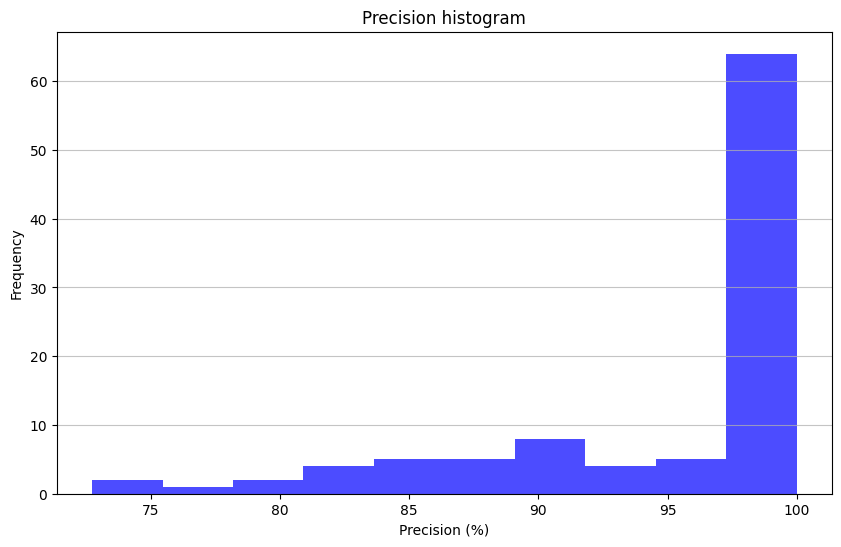

In [58]:
import matplotlib.pyplot as plt
df = pd.read_csv('./data/metrics/second_step/big_llama3_1.csv')

precision = df['precision']

plt.figure(figsize=(10, 6))
plt.hist(precision, bins=10, color='blue', alpha=0.7)
plt.title('Precision histogram')
plt.xlabel('Precision (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [50]:
len({'Madre': 'FAMILIARES_SUJETO_ASISTENCIA', '5/2026': 'FECHAS', 'C. La Salud': 'CENTRO_SALUD', '10': 'FECHAS', '13/12/26': 'FECHAS', '08/11': 'FECHAS', '6/2027': 'FECHAS', '09/10/27': 'FECHAS', '82/1/2027': 'FECHAS', '2/05/28': 'FECHAS', '07/12/27': 'FECHAS', '22/09/27': 'FECHAS', '13/10/28': 'FECHAS', '20/03/29': 'FECHAS', 'abr': 'FECHAS', 'jul de 2027': 'FECHAS', '15/08': 'FECHAS', '6/7/29': 'FECHAS', '13/11/28': 'FECHAS', '31/12/2028': 'FECHAS', '31/01/29': 'FECHAS', 'juny': 'FECHAS', 'Desembre': 'FECHAS'}
)

23

In [51]:
len({'Madre': 'FAMILIARES_SUJETO_ASISTENCIA', '5/2026': 'FECHAS', 'C. La Salud': 'HOSPITAL', '7/2026': 'FECHAS', '10': 'FECHAS', '13/12/26': 'FECHAS', '08/11': 'FECHAS', '6/2027': 'FECHAS', '09/10/27': 'FECHAS', '82/1/2027': 'FECHAS', '2/05/28': 'FECHAS', '07/12/27': 'FECHAS', '22/09/27': 'FECHAS', '13/10/28': 'FECHAS', '20/03/29': 'FECHAS', 'abr': 'FECHAS', 'jul de 2027': 'FECHAS', '15/08': 'FECHAS', '6/7/29': 'FECHAS', '13/11/28': 'FECHAS', '31/12/2028': 'FECHAS', '31/01/29': 'FECHAS', 'juny': 'FECHAS', 'Desembre': 'FECHAS'}
)

24

In [1]:
from tqdm import tqdm 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def visualization_label_classification(file):
    df = pd.read_csv(file, index_col=0)

    y_true = []
    y_pred = []

    for i in range(len(df)):
        row = df.iloc[i]

        data = {
            'real' : eval(row.real), 
            'predicted' : eval(row.predicted), 
            'fail': eval(row.fails), 
            'miss': eval(row.miss)
        }

        # Add correctly classified words
        for key in data['real']:
            if key in data['predicted'].keys():
                y_true.append(data['real'][key])
                y_pred.append(data['real'][key])

        # Add incorrectly classified words
        for key in data['fail']:
            y_true.append(data['fail'][key][0])
            y_pred.append(data['fail'][key][1])


        for word in data['miss']:
            y_true.append(data['real'][word])
            y_pred.append('missing')

    categories = list(set(y_pred+y_true))

    
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred, labels=categories, normalize='true')

    # Convertir la matriz en un DataFrame
    conf_matrix_df = pd.DataFrame(conf_matrix, index=categories, columns=categories)

    # Eliminar la fila "missing" (si existe) del DataFrame
    if 'missing' in conf_matrix_df.index:
        conf_matrix_df = conf_matrix_df.drop('missing', axis=0)


    # Ajustar la visualización
    plt.figure(figsize=(15, 13))
    sns.heatmap(conf_matrix_df, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, linecolor='gray', square=True, cbar=True, cbar_kws={'shrink': 0.75})

    # Títulos y etiquetas
    plt.title('Relationship Between Real and Predicted Categories', fontsize=18, pad=20)
    plt.xlabel('Predicted Categories', fontsize=14)
    plt.ylabel('Real Categories', fontsize=14)

    # Ajustes estéticos adicionales
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)

    # Mostrar la gráfica
    plt.show()

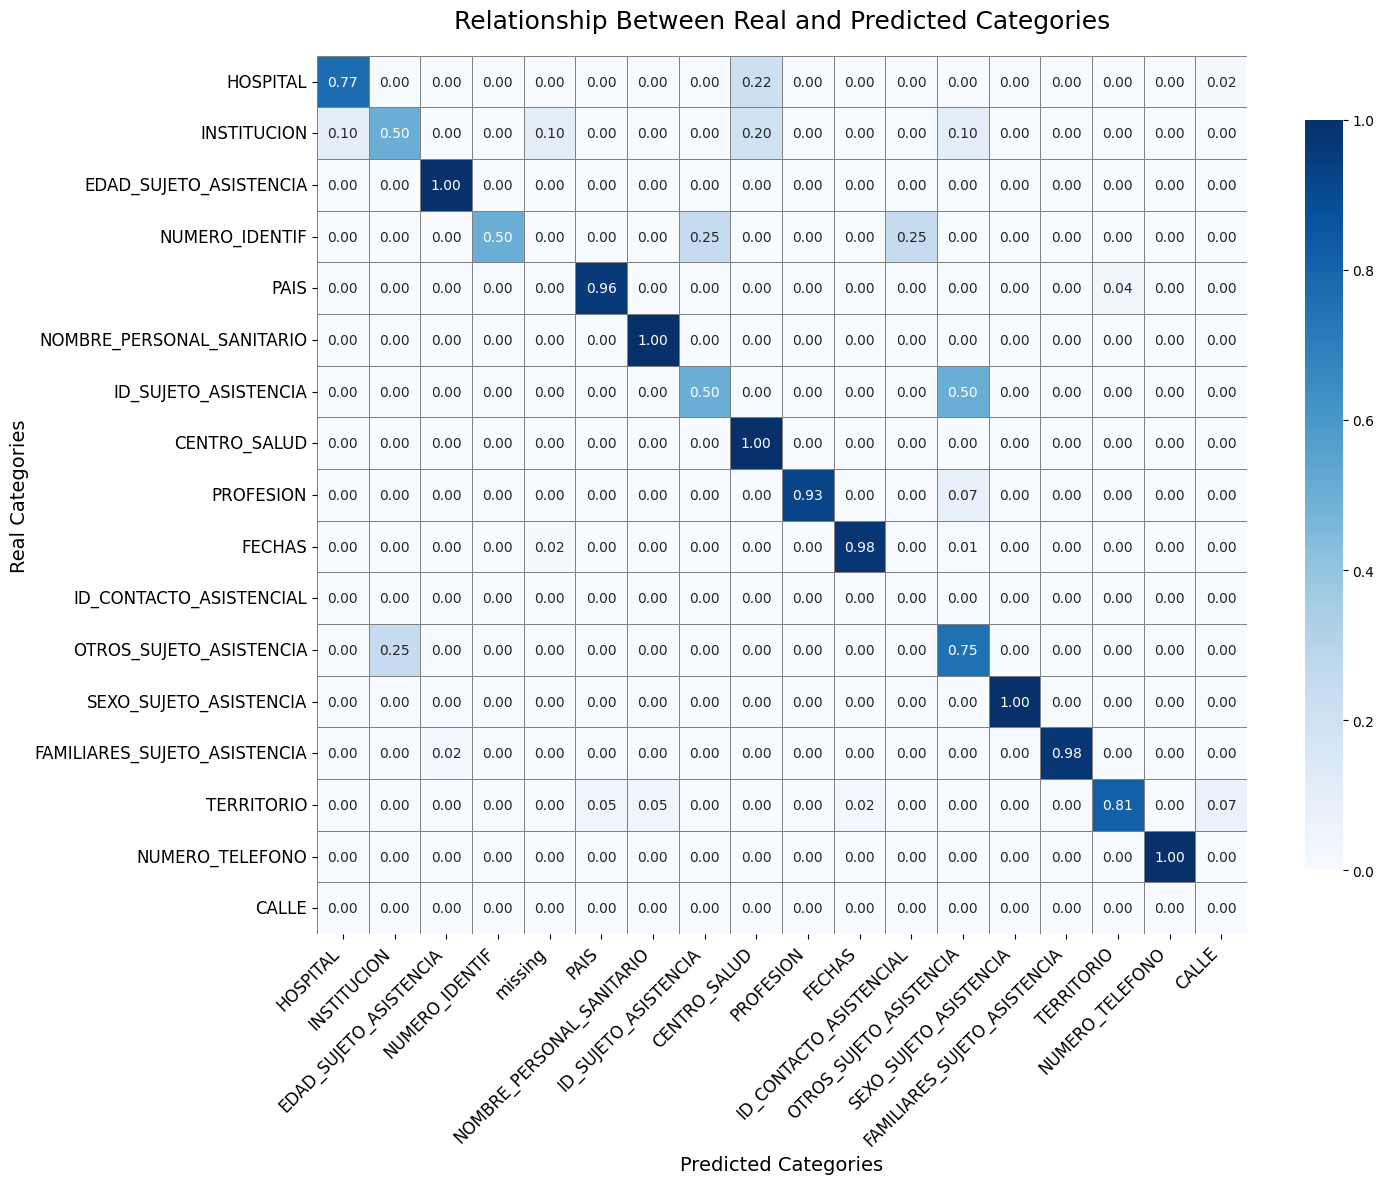

In [11]:
visualization_label_classification('./data/metrics/second_step/big_llama3_1.csv')

In [24]:
from llm.strategy.opus3_model import OpusModel


def get_text_and_masked_carmen(name):
    filename = f'./data/processed/txt/{name}'
    filename_result = f'./data/processed/masked/{name}'
    with open(filename, 'r') as archivo:
        text = archivo.read()

    with open(filename_result, 'r') as archivo:
        text_masked = archivo.read()

    return [text, text_masked]


import json
def anonimized(llm=None, name_model="", data=None):
    counter = 0
    context = LLMContext(llm)
    list_data  = []
    for name in sorted(os.listdir(PATH)):
        filename = f'./data/processed/txt/{name}'
        with open(filename, 'r') as archivo:
            text = archivo.read()
        print(len(text))
        counter += len(text)
    print(counter)
anonimized(llm=OpusModel(), name_model="opus3", data=data)
        

1303
3411
1786
1721
2022
2957
1038
2316
3885
1948
965
1869
2338
889
3688
223
1675
1703
1177
1758
1049
1817
574
1422
534
1171
1366
332
5933
3243
1734
2122
2230
1358
3650
824
2810
1596
5032
507
3718
3440
1385
2263
2068
451
756
816
3934
350
1454
2222
1323
2229
577
3087
2340
2386
635
550
2348
399
830
711
2979
2495
594
2074
220
1363
766
4295
980
318
500
2800
209
1068
1652
522
4443
2116
1785
2690
461
1142
1733
963
1939
4892
441
2610
285
537
351
2668
1238
2184
939
1474
3663
3751
3248
3238
370
397
1879
2391
872
170
1454
394
852
996
511
2095
938
1942
1990
3485
3957
2965
4322
1220
2110
2164
1617
752
1143
1372
2225
1501
4441
2380
3048
1059
153
1171
2507
2816
2690
1527
2674
3118
3871
5170
3461
2047
2950
2053
4651
1065
1758
2848
4907
1459
1586
1566
5516
2165
1506
3231
4008
1599
3716
2847
2424
4071
5296
3712
1979
2453
2914
1679
2232
2443
2955
1750
2498
2764
7799
2432
3578
1885
2012
3596
3640
3621
4336
1926
2119
3574
1541
1165
2650
1784
2522
4348
1313
4757
779
3596
2656
3994
2378
6761
2961
4206
636
1

In [7]:
total_words = 2653788

## Llama

### Small llama

In [8]:
llama3_price_input = total_words * 0.00032/1000
llama3_price_output = total_words * 0.00065/1000
llama_small = llama3_price_input + llama3_price_output
print(llama_small)

2.5741743599999998


### Big llama

In [9]:
llama3_big_input = total_words * 0.00286 / 1000
llama3_big_output = total_words * 0.00378 / 1000
llama_big = llama3_big_input + llama3_big_output
print(llama_big)

17.62115232


### Llama 3_1

In [10]:
llama3_1_input = total_words * 0.00532 / 1000
llama3_1_output = total_words * 0.016 / 1000
llama3_1 = llama3_1_input + llama3_1_output
print(llama3_1)

56.57876016


## Antropic

### Claude 3_5

In [11]:
claude_sonet_3_5_input = total_words * 0.003/1000
claude_sonet_3_5_output = total_words * 0.015/1000
claude_sonet_3_5 = claude_sonet_3_5_input + claude_sonet_3_5_output
print(claude_sonet_3_5)

47.768184000000005


### Claude Opus

In [12]:
claude_opus_input = total_words * 0.015 / 1000
claude_opus_output = total_words * 0.075 / 1000
claude_opus = claude_opus_input + claude_opus_output
print(claude_opus)

238.84091999999998


### Claude Sonnet 3

In [13]:
claude_sonet_3_input = total_words * 0.003/1000
claude_sonet_3_output = total_words * 0.015/1000
claude_sonet_3 = claude_sonet_3_input + claude_sonet_3_output
print(claude_sonet_3)

47.768184000000005


### Claude Haiku 3

In [14]:
claude_haiku_3_input = total_words * 0.00025/1000
claude_haiku_3_output = total_words * 0.00125/1000
claude_haiku_3 = claude_haiku_3_input + claude_haiku_3_output
print(claude_haiku_3)

3.9806820000000003


## Mistral

In [15]:
claude_mistral_input = total_words * 0.00049/1000
claude_mistral_output = total_words * 0.00076/1000
claude_mistral = claude_mistral_input + claude_mistral_output
print(claude_mistral)

3.317235


In [17]:
total = claude_sonet_3_5 + claude_opus + claude_sonet_3 + claude_haiku_3 + claude_mistral + llama_small + llama_big + llama3_1
print(total)

418.44929184


# First iteration 

In [15]:
def read_text(filename=None):
    with open(filename, 'r') as archivo:
        return archivo.read()

In [16]:
text_1 = read_text("../prompts/system_prompt1.txt")
text_1 = len(text_1.split())
text_2 = read_text("../prompts/system_prompt2.txt")
text_2 = len(text_2.split())

In [17]:
import os
array_texts_raw = []
array_prompt = []
array_prompt_2 = []
for filename in sorted(os.listdir("carmen/txt/masked/")):
    text = read_text(f"carmen/txt/masked/{filename}")
    text = len(text.split())
    array_prompt.append(text+text_1)
    array_prompt_2.append(text+text_2)
    array_texts_raw.append(text)

In [41]:
import numpy as np
total = np.sum(array_texts_raw)
total

425758

In [30]:
def price_calculator(input_price, output_price):
    total = 0
    for text_raw, text_prompt_1, text_prompt_2 in zip(array_texts_raw, array_prompt, array_prompt_2):
        input_1 = text_prompt_1 * input_price/1000
        output = text_raw * output_price/1000
        input_2 = text_prompt_2 * input_price/1000
        total = input_1 + input_2 + output + output + total
    print(total)
    return total

# Llama 

In [31]:
small_llama_price = price_calculator(0.00032, 0.00065)
llama3_price = price_calculator(0.00286, 0.00378)
llama3_1_price = price_calculator(0.00532, 0.016)

1.1901305200000005
8.908746240000008
24.208481119999966


# Antropic

In [32]:
sonet_3_price = price_calculator(0.003, 0.015)
sonet_3_5_price = price_calculator(0.003, 0.015)
opus_price = price_calculator(0.015, 0.075)
haiku_price = price_calculator(0.00025, 0.00125)
mistral_price = price_calculator(0.00049, 0.00076)

18.741288000000054
18.741288000000054
93.70643999999965
1.5617740000000009
1.622015000000002


In [33]:
total = sonet_3_price + sonet_3_5_price + opus_price + haiku_price + mistral_price + small_llama_price + llama3_price + llama3_1_price

In [34]:
total

168.68016287999973